In [89]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.backend.set_floatx('float64')
import tenfem
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.tri import Triangulation
from tenfem.layers import (AssembleStiffnessMatrix, AssembleLoadVector, SolveDirichletProblem,
                           TriangleMeshInterpolator)

tf_dtype = tf.float64
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

tf.random.set_seed(123)
np.set_printoptions(precision=3, suppress=True)
num_inducing_points = 50

# Background

Solving a linear PDE like

$$
    \mathcal{L}u(x) = f(x),
$$

can be thought of as an operator which maps the source term $f(x)$ to a new function
$u(x)$, this operator is linear and so properties, such as Gaussianity, are preserved.
In this note we explore a little bit more of this feature, in particular it allows
us to regard PDEs as a special form of *mechanistically inspired smoothing kernel*, and
and so make their use much natural for people in the statistical and machine learning
communities who are more likely to be familiar with Gaussian processes.

Formally we might write this convolution as

$$
    u(x) = \mathcal{L}^{-1}f(x), 
$$

then if $f(x) \sim \mathcal{GP}(0, k_f(x, x'))$, we have

$$
    u(x) \sim \mathcal{GP}(0, \mathcal{L}^{-1} \otimes \mathcal{L}^{-\top} [k] (x, x') ),
$$

but what does this mean? This notebook demonstrates the basic idea while using the functionality
of `Tenfem` to explore these features

## Green's functions and kernels

The *Green's function*, say $k_x(x')$, of a linear PDE is a solution to the problem

$$
    \mathcal{L} k_x(y) = \delta(x-y), \qquad y \in \Omega
$$

where $\delta(x-x')$ is the Dirac delta function. Knowing this solution for the Dirac delta source
allows one to obtain the solution for a General source by the convolution

$$
    u(x) = \int_{\Omega} k_x(y) f(y) dy
$$

Lets make this clearer with an example, let our domain be $\Omega = [0, 1]$ and our operator 
be $\mathcal{L} = -\Delta = \frac{\partial^2}{\partial x}$, then one can check that a Greens function
for this problem is given by

$$
    k(x, y) = \begin{cases} x(1-y) \qquad &\text{if } x \leq y \\
    y(1-x) \quad &\text{otherwise.}
    \end{cases}
$$

the covariance operator of the Brownian bridge on $[0, 1]$. So then a solution is given by
the convolution

$$
\begin{align}
   u(x) &= \left(-\frac{\partial^2}{\partial x^2}\right)^{-1} \\
   &=\int_{0}^{x}x(1-y) f(y) dy + \int_{x}^{1}y(1-x)f(y) dy.
\end{align}
$$

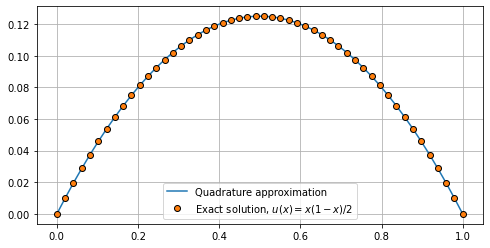

In [72]:
def build_interval_mesh_and_element(n_nodes):
    """ Build an `IntervalMesh` on the interval [0, 1] and the reference element. """
    a, b = (0, 1)
    nodes = np.linspace(a, b, n_nodes)[:, np.newaxis]
    elements = np.column_stack((np.arange(0, n_nodes-1), np.arange(1, n_nodes)))
    boundary_elements = [[0, ], [n_nodes-1, ]]
    ref_element = tenfem.reference_elements.IntervalElement(degree=1, dtype=tf.float64)
    return tenfem.mesh.IntervalMesh(nodes, elements, boundary_elements), ref_element

def bb_kernel(x, y):
    """ Covariance function of the Brownian bridge. """
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    return tf.squeeze(tf.where(x <= y, x*(1-y), y*(1-x)))


def f(x):
    return 1.

xx = np.linspace(0., 1.)
vals = []
for x in xx:
    vals.append(element.quadrature(lambda y: f(y) * bb_kernel(x, y), mesh))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(xx, vals, label='Quadrature approximation')
ax.plot(xx, .5*xx*(1-xx), 'o', markeredgecolor='k', label='Exact solution, $u(x) = x(1-x)/2$')
ax.legend()
ax.grid()
plt.show()

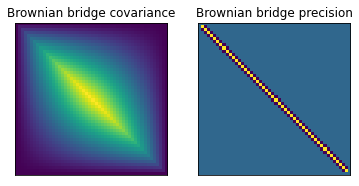

In [90]:
x1 = np.linspace(0., 1.)[:, None]
x2 = np.linspace(0., 1.)[None, :]
k = bb_kernel(x1, x2)
kinv = np.zeros_like(k)
kinv[1:-1, 1:-1] = np.linalg.inv(k[1:-1, 1:-1])
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(k)
axes[1].imshow(kinv)

titles = ['Brownian bridge covariance',
          'Brownian bridge precision', ]


for i, ax in enumerate(axes.ravel()):
    for method in [ax.set_xticks, ax.set_yticks]:
        method([])
    ax.set_title(titles[i])
plt.show()

In summary we can solve this simple PDE by forming the new function

$$
   u(x) = \int_{0}^{x}x(1-y) f(y) dy + \int_{x}^{1}y(1-x)f(y) dy,
$$

# Introduction

In the [Notebook](hello_poisson.ipynb) we introduced the basic process of
solving the Poisson problem with constant source. This seemed to work just fine,
but giving the prior existence of FEM solving software packages why have we gone
to all the additional work of implementing these methods inside of the Tensorflow
ecosystem? In this notebook we being to make this abit clearer by considering a
much more interesting class of models obtained by replacing the relatively
boring source of the previous examples with the tensorflow implementation of the
`GaussianProcess` class. That is we shall consider the solution of PDE systems of the
form

$$
\begin{align}
    -\nabla ( a(x) \nabla u(x) ) &= f(x) \qquad x \in \Omega \\
    u(x) &= g(x) \qquad x \in \partial\Omega \\
\end{align}
$$

where the source term, $f(x)$, and the boundary condition $g(x)$, are both
given independent Gaussian process priors.

$$
\begin{align}
    f(x) &\sim \mathcal{GP}(0, k_f), \\
    g(x) &\sim \mathcal{GP}(0, k_g)
\end{align}
$$

where the source function is now a mean zero Gaussian process with kernel function $k$.
We show that it is simple to put together this model, and for the cost of implementing
the FEM solver we have gained access to the full set of statistical and machine learning
models implemented in TensorFlow

### Domain creation
Before proceeding to define this part of the model, lets create our problem domain
$\Omega$, again we will use a simple example mesh which is the unit square
$\Omega = [0, 1] \times [0, 1]$. We will also rescale this domain to give our 
GP variables some "wiggle" room.

In [ ]:
mesh = tenfem.mesh.examples.square(20, 20, dtype=tf_dtype)
# rescale the mesh a bit
mesh = tenfem.mesh.TriangleMesh(3 * mesh.nodes,
                                mesh.elements,
                                mesh.boundary_elements)
mesh.add_matplotlib_tri()

# Creating the GP model


## The kernel function
In this example we shall take the kernel function of our Gaussian process to be popular
exponentiated quadratic, or radial basis function (RBF) kernel

$$
    k(x, x') = \alpha^2 \exp\left(-\frac{1}{2} \sum_{d=1}^D (x_d - x'_d ) / \ell_d^2 \right)
$$

where $\alpha$ is the *amplitude* parameter, and $\ell$ is the *length-scale* parameter. 

We want to implement the GP model inside of the `tf.keras` functional API using the layers
created by the `tensorflow_probability` team. To do so we are going to need a layer whose
job is provide the kernel function to the Gaussian process. This layers job is to hold the
model parameters, and simple layer class to do this job taken from 
the [tfp examples]() is given below

In [ ]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)

        self._amplitude = self.add_weight(
                initializer=tf.constant_initializer(0),
                dtype=dtype,
                name='amplitude')

        self._length_scale = self.add_weight(
                initializer=tf.constant_initializer(0.5),
                dtype=dtype,
                name='length_scale')

    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
          amplitude=tf.nn.softplus(0.1 * self._amplitude),
          length_scale=tf.nn.softplus(0.1 * self._length_scale))

## `VariationalGaussianProcess`

Read more about these process at ... first we are just going to define a function
to build these layers, and then give a bit more of a recap of what is going on

In [ ]:
def build_gp_layer(kernel_fn='RBF'):
    """ Simple function to quickly build a SVGP layer. """
    if kernel_fn != 'RBF':
        raise NotImplementError('Add more kernel functions!')

    # select the initial inducing points uniformly from the mesh node
    z_indices = np.random.choice(mesh.interior_node_indices.numpy(), 
                                 size=num_inducing_points, 
                                 replace=False)
    z = mesh.nodes.numpy()[z_indices]

    # initialize q(u) at the prior
    kernel_provider = RBFKernelFn(dtype=tf.float64)
    kzz = kernel_provider.kernel.matrix(z, z)
    scale = tf.linalg.cholesky(kzz).numpy()

    gp_layer = tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(z),
        variational_inducing_observations_scale_initializer=tf.constant_initializer(scale),
        jitter=1e-4)
    return gp_layer

A Gaussian process determines the distribution of finite samples 
$\mathbf{f} = (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_n) )$, a sparse
variational Gaussian process introduces an additional set of 
*inducing variables* denoted by $\mathbf{u}$ with distribution
$q(\mathbf{u})$ and then approximates the distribution over the
complete set of $\mathbb{f}$ by the factorised

$$
    p(\mathbf{f}, \mathbf{u}) = 
    p(\mathbf{f} \mid \mathbf{u}) q(\mathbf{u}).
$$

For Gaussian observations the parameters of $q(\mathbf{u})$ can
be determined analytically. For more complex models these are
instead freely optimised, in which case we specify

$$
    q(\mathbf{u}) = \mathcal{N}(\mathbf{u} \mid \mathbf{m}, \mathbf{LL}^{\top})
$$

where $\mathbf{L}$ is a lower-triangular matrix. For
`num_inducing_points = M` this is a total of 
$M + M(M+1)/2$ parameters.

In the examples below we use the
*inducing points variables* which are additional samples of the
process $f(\mathbf{x})$ drawn at locations 
$\mathbf{Z} = \{ \mathbf{z}_m \}_{m=1}^M$. This gives the
following set of parameters

* $\mathbf{Z}$ -- the `inducing_point_locations`
* $\mathbf{m}$ -- the `variational_inducing_observations_loc`
* $\mathbf{L}$ -- the `variational_inducing_observations_scale`

this variables can be accessed by passing a variable through the GP
and querying the output. This is a bit sketchy, the name of the
object returned by a GP layer is a mess of transposes and transformed
distribution which is a little hard to parse, but if we print the
variables we see they are what we would expect

In [ ]:
inputs = tfkl.Input(2)
gp_layer = build_gp_layer()
f = gp_layer(inputs)
for item in f.variables:
    print(item.name)

What we want is a `tfpl` layer which will return a
`tfd.distributions.VariationalGaussianProcess` object.

We are going to initialise the locations of the inducing points at the a 
selection of randomly sampled nodes on the mesh, and the distribution
$q(\mathbf{u})$ at the prior

We are also going to add a further layer transforming our inputs to the parameters
of the kernel function
```
    Input ---> Dense(2) ---> VariationalGaussianProcess
```
This layer does simple rescaling of the parameters, but obviously one is
free to extend this idea adding more and more layers to warp the input space
which will be points in $\Omega$. Clearly this approach to model building can be
easily adapted to join multiple spaces etc.

We leave the exploration of the full possibilities for the reader and future notebooks
and for now just implement the simple model shown above. We can put the source
together as a full model and use the `.summary()` method to check everything is
working as expected.

In [ ]:
inputs = tfkl.Input(2)
# x = tfkl.Dense(2, use_bias=False)(inputs)  # scales inputs (like a length_scale)
f = build_gp_layer('RBF')(inputs)
source = tfk.Model(inputs=inputs, outputs=f, name='source')
source.summary()

# Implementing the FEM model

We have the following steps
1. Define the source model
2. Define the Dirichlet boundary condition model
3. Define the diffusion coefficient model
4. Combine

In [ ]:
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)
quad_mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)

diffusion_coefficient = lambda x: tf.ones_like(x[..., 0])[..., tf.newaxis] # tfkl.Dense(1, activation='softplus')

### The boundary condition $u_D$

We are also going to assign a GP to the values of $u$ on the boundary, that
is 

$$
    u_{D}(x) \sim GP(0, k_D(x, x'))
$$

and as with the source model we make this using the `VariationalGaussianProcessLayer`

In [ ]:
# GP model to give the boundary values
inputs = tfkl.Input(2)
f = build_gp_layer('RBF')(inputs)
ud = tfk.Model(inputs=inputs, outputs=f, name='boundary')
ud.summary()

### The full latent GP PDE

In [ ]:
mesh_provider = tenfem.layers.MeshProvider(quad_mesh, element)

ud = lambda x: tf.zeros_like(x[..., 0])[..., tf.newaxis]

gp_pde = tenfem.layers.LinearEllipticOperator(
    diffusion_coefficient=diffusion_coefficient,
    source=source,
    boundary_values=ud,
    reference_element=element)

interp = tenfem.layers.TriangleMeshInterpolator(
    tri_finder = mesh._triang.get_trifinder(),
    reference_element=element)

# create the model using the tf.keras functional API
inputs = tfkl.Input(shape=(2, ))
mesh_tensor_repr = mesh_provider(inputs)

u = gp_pde(mesh_tensor_repr)  # solution of the model at the tensor nodes
outputs = interp([inputs, u, mesh_tensor_repr])

gp_pde_model = tfk.Model(inputs=inputs, outputs=outputs)
gp_pde_model.summary()

lets sample some realisations of this model to see what sort of patterns we can realise

In [ ]:
xx = np.linspace(0., np.max(mesh.nodes[:, 0]))
yy = np.linspace(0., np.max(mesh.nodes[:, 1]))
xx, yy = np.meshgrid(xx, yy)
points = np.column_stack((xx.ravel(), yy.ravel()))

fig, axes = plt.subplots(ncols=3, figsize=(10, 5))

for i in range(3):
    #u = interp([points, source(quad_mesh.get_tensor_repr()), quad_mesh.get_tensor_repr()])
    #u = u.numpy().reshape(xx.shape)
    u = gp_pde_model(points).numpy().reshape(xx.shape)
    axes[i].contourf(xx, yy, u, levels=20)
for ax in axes.flatten():
    ax.set_aspect('equal')

In [ ]:
assert(False)

In [ ]:
# GP model to give the boundary values
inputs = tfkl.Input(2)
f = build_gp_layer('RBF')(inputs)
ud = tfk.Model(inputs=inputs, outputs=f, name='boundary')
# ud.summary()

In [ ]:
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)
quad_mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)

diffusion_coefficient = tfkl.Dense(1, activation='softplus')

def sample_source(x, seed=123):
    tf.random.set_seed(seed)
    return np.squeeze(source(x).sample(1))

def solve(mesh, element, seed=123):
    """ Simple function so solve the PDE"""
    tf.random.set_seed(seed)
    pde = tenfem.layers.LinearEllipticOperator(
        diffusion_coefficient=diffusion_coefficient,
        source = source,
        boundary_values=ud,
        reference_element=element)
    u = pde(mesh.get_tensor_repr())
    return u

In [ ]:
f = sample_source(quad_mesh.nodes, seed=8124)
u = solve(quad_mesh, element, seed=8124)

In [ ]:
interp = tenfem.layers.TriangleMeshInterpolator(
    tri_finder = mesh._triang.get_trifinder(),
    reference_element=element)

In [ ]:
xx = np.linspace(0., 3.)
yy = np.linspace(0., 3.)
xx, yy = np.meshgrid(xx, yy)
points = np.column_stack((xx.ravel(), yy.ravel()))
uinterp = interp([points, u, quad_mesh.get_tensor_repr()]).numpy()

In [ ]:
fig, ax = plt.subplots()
ax.contourf(xx, yy, uinterp.reshape(xx.shape), levels=20)#, cmap='Spectral')
ax.set_aspect('equal')

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4))

mtri = Triangulation(*quad_mesh.nodes.numpy().T)

vals = [f, u[:, 0]]
cm = ['plasma', 'Spectral']

for i, ax in enumerate(axes):
    cs = ax.tricontourf(mtri, vals[i], cmap=cm[i], levels=15)
    ax.set_aspect('equal')

plt.show()

In [ ]:
from sklearn.datasets import fetch_species_distributions


In [ ]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
#Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)

In [ ]:
from scipy.spatial import Delaunay
from sklearn.datasets import make_moons

data = make_moons(noise=0.3, random_state=0)

X, y = data

bbox = (np.min(X[:, 0]) - 0.1, 
        np.max(X[:, 0]) + 0.1, 
        np.min(X[:, 1]) - 0.1, 
        np.max(X[:, 1]) + 0.1)

xx = np.linspace(bbox[0], bbox[1], 16)
yy = np.linspace(bbox[2], bbox[3], 16)

xx, yy = np.meshgrid(xx, yy)

nodes = np.column_stack((xx.ravel(), yy.ravel()))
tri = Delaunay(nodes)

tri_mesh = tenfem.mesh.TriangleMesh(tri.points, tri.simplices, tri.convex_hull, dtype=tf_dtype)
tri_mesh.add_matplotlib_tri()

fig, ax = plt.subplots()
ax.triplot(tri_mesh._triang, alpha=0.4)
ax.set_aspect('equal')
ax.plot(*X[y == 0].T, 'C0o', markeredgecolor='k')
ax.plot(*X[y == 1].T, 'C1o', markeredgecolor='k')
plt.show()

In [ ]:
tfd = tfp.distributions

inputs = tfkl.Input(2)
x = tfkl.Dense(2)(inputs)  # scales inputs (like a length_scale)
f = tfkl.Dense(16, activation='relu')(x)
f = tfkl.Dense(16, activation='relu')(f)
pred = tfkl.Dense(2)(f)

model = tfk.Model(inputs=inputs, outputs=pred)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
model.fit(X, y[:, None], batch_size=128, epochs=1000)

In [ ]:
pred = model.predict(tri_mesh.nodes)

In [ ]:
fig, ax = plt.subplots()
ax.contourf(xx, yy, pred[:, 0].reshape(xx.shape), cmap='Spectral')
ax.plot(*X[y == 0].T, 'C0o', markeredgecolor='k')
ax.plot(*X[y == 1].T, 'C1o', markeredgecolor='k')
ax.set_aspect('equal')
plt.show()

In [ ]:
y.shape[1:]

In [ ]:
fig, ax = plt.subplots()
ax.plot(*Xtrain.T, 'o', markeredgecolor='k')

In [ ]:
# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
#Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)

In [ ]:
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > 100).ravel()

fig, ax = plt.subplots(figsize=(6, 10))
cs = ax.contourf(X, Y, land_reference,
                 levels=[0, 10, 100], colors="k",
                 linestyles="solid")

ax.plot(Xtrain[:, 1], Xtrain[:, 0], 'o', markeredgecolor='k')

ax.set_aspect('equal')

In [ ]:
p = cs.collections[0].get_paths()[0]
v = p.vertices

In [ ]:
fig, ax = plt.subplots()
ax.plot(v[:, 0], v[:, 1], '-')
plt.show()


In [ ]:
land_reference[land_reference > 100].shape

In [ ]:
!pip install geopandas

In [ ]:
# Import necessary modules
import geopandas as gpd

# Set filepath
fp = "SouthAmerica.shp"

# Read file using gpd.read_file()
data = gpd.read_file(fp)

In [ ]:
data

In [ ]:
import geopandas

In [ ]:
capitals = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Create a subset of the world data that is just the South American continent
south_america = world[world["continent"] == "South America"]

In [ ]:
fig, ax = plt.subplots()
south_america.boundary.plot(ax=ax, color="green")
ax.set_aspect('equal')
plt.show()

In [ ]:
south_america

In [ ]:
colombia = world[world.name == 'Colombia']
panama = world[world.name == 'Panama']
costa_rica = world[world.name == 'Costa Rica']
brazil = world[world.name == 'Brazil']
venezuela = world[world.name == 'Venezuela']

country_names = ['Colombia', 'Venezuela', 'Ecuador', 'Peru', 'Bolivia', 'Chile', 'Brazil',
                 'Guyana', 'Paraguay', 'Argentina']
                 #'Suriname', 'French Guiana', 'Paraguay', ]

countries = [world[world.name == name] for name in country_names]

In [ ]:
polygons = list(map(lambda x: x.geometry.iloc[0], countries))

In [ ]:
import shapely
shapely.ops.unary_union(polygons)